In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
ADVERSARY_PATH = 'Models\Adversary\default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
ATTACK = 'Optimal myBB closest init'
INIT_DATA = 'baseline_obs'

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

%matplotlib inline

Define RL agent

In [3]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [4]:
adv_path = os.path.join(os.getcwd(), '..',ADVERSARY_PATH) #get adversary from parent directory
adv_path = os.path.normpath(adv_path) #resolve '..'
adversary = PPO.load(path=adv_path)
print('Model loaded from storage')

Model loaded from storage


In [5]:
env = utils.make_discrete_env(schema=DataSet.get_schema(DATASET_NAME),  
                        action_bins=agent.action_space[0].n,
                        seed=42)

In [6]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [7]:
df_baseline = pd.concat([pd.read_csv(f'{INIT_DATA}.csv', index_col=0,dtype='float32'),
                        pd.read_csv(f'{INIT_DATA}_a_confidence.csv', index_col=0)], axis='columns')

Below we are making a dict which contains a 2d array of samples corresponding to each action, so the attack can select a sample of the target class closest to the clean input as an initialization.

After a few tens of iterations this had an ASR of 0.9, uncertain why

In [8]:
muti_sample_dict = df_baseline.drop(columns=['confidence','action']).groupby(df_baseline['action']).apply(np.array).to_dict()

Below, for each action we select the sample with the highest logit softmax/confidence

In [9]:
df_max_confidence_samples = df_baseline.loc[df_baseline.groupby('action')['confidence'].idxmax()]
df_max_confidence_samples = df_max_confidence_samples.drop(columns='confidence')
df_max_confidence_samples = df_max_confidence_samples.set_index('action')
max_conf_dict = df_max_confidence_samples.groupby('action').apply(np.array).to_dict()

In [ ]:
%%time
import logging
logging.basicConfig(level=logging.WARN)
kwargs = dict(norm=np.inf,
        targeted=True, #default false
        overshoot= 1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1000, 
        )
kpi, obs, adv_obs, actions, targets, asr = utils.eval_targeted_attack(agent, adversary, 
                                                                        env=env, 
                                                                        ART_atk=utils.define_attack(agent, BBA, **kwargs),
                                                                        mask=observation_masks['mask_time'].to_numpy(),
                                                                        time_steps=None,
                                                                        x_adv_init = muti_sample_dict #random search is more effective for finding starting points?!
                                                                        )
#print(f'The ASR is {asr}')

In [ ]:
display(kpi)

cost_function
annual_peak_average                       1.727378
carbon_emissions_total                    3.230139
cost_total                                3.036743
daily_one_minus_load_factor_average       0.960458
daily_peak_average                        2.930483
electricity_consumption_total             3.272208
monthly_one_minus_load_factor_average     1.002596
ramping_average                          17.457390
zero_net_energy                           1.731706
Name: District, dtype: float64

In [ ]:
np.savetxt(f"{ATTACK} targets.csv", targets, delimiter=",")
np.savetxt(f"{ATTACK} actions.csv", actions, delimiter=",")
np.savetxt(f"{ATTACK} adv obs.csv", adv_obs, delimiter=",")
np.savetxt(f"{ATTACK} obs.csv", obs, delimiter=",")

In [ ]:
df_kpis = pd.read_csv('KPIs.csv', index_col='cost_function')
df_kpis

,baseline,random_noise,untargeted_acg,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis,df_v_ablation_kpis,optimal_acg,optimal_BB,optimal_myBB,untargeted_bb
cost_function,,,,,,,,,,,
annual_peak_average,1.102271,1.009338,1.198347,1.102271,1.102270,1.102271,1.068404,1.102260,1.727378,1.727378,1.198347
carbon_emissions_total,0.869186,0.870929,0.902045,0.891469,0.900611,0.880414,0.889796,0.876466,3.230139,3.230139,0.917995
cost_total,0.787803,0.786467,0.816997,0.805982,0.814078,0.799415,0.806549,0.795443,3.036743,3.036743,0.830110
daily_one_minus_load_factor_average,1.095762,1.091588,0.397182,1.002500,0.997434,0.365708,1.050107,1.045433,0.960458,0.960458,1.412863
daily_peak_average,0.894595,0.896781,0.961207,0.930231,0.945812,0.913327,0.939143,0.912418,2.930483,2.930483,1.005608
electricity_consumption_total,0.879108,0.881392,0.910717,0.901177,0.909467,0.890338,0.898543,0.885576,3.272208,3.272208,0.928516
monthly_one_minus_load_factor_average,0.988364,0.981307,0.992850,0.987415,0.991820,0.986949,0.993147,0.990366,1.002596,1.002596,0.997774
ramping_average,1.093749,1.105215,1.271853,1.196971,1.230539,1.151861,1.216366,1.122770,17.457390,17.457390,1.331715
zero_net_energy,1.107710,1.107912,1.108499,1.109079,1.108982,1.108470,1.108584,1.108495,1.731706,1.731706,1.109182


In [ ]:
df_kpis[f'optimal_{ATTACK}'] = kpi.values

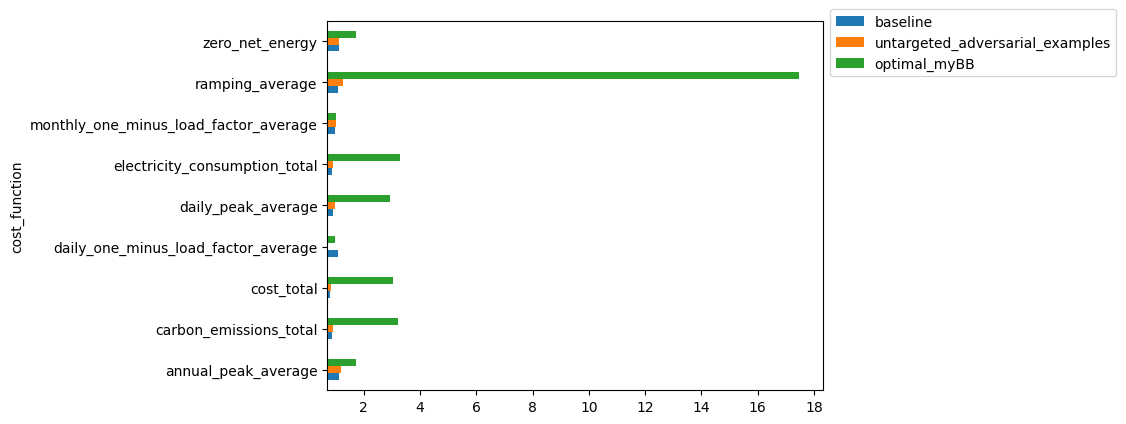

In [ ]:
df_kpis[['baseline','untargeted_adversarial_examples',f'optimal_{ATTACK}']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [ ]:
df_kpis.to_csv('KPIs.csv')